In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 216ms/step - loss: 0.6796 - root_mean_squared_error: 0.8244 - val_loss: 0.5007 - val_root_mean_squared_error: 0.7076
Epoch 2/50
53/53 [==============================] - 10s 200ms/step - loss: 0.4499 - root_mean_squared_error: 0.6708 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4049
Epoch 3/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0707 - root_mean_squared_error: 0.2658 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3034
Epoch 4/50
53/53 [==============================] - 11s 201ms/step - loss: 0.0590 - root_mean_squared_error: 0.2429 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2919
Epoch 5/50
53/53 [==============================] - 11s 202ms/step - loss: 0.0545 - root_mean_squared_error: 0.2335 - val_loss: 0.0782 - val_root_mean_squared_error: 0.2797
Epoch 6/50
53/53 [==============================] - 10s 193ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.0744 

Epoch 29/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1984
Epoch 30/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1988
Epoch 31/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 32/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1979
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0322 - root_mean_squared_error: 0.1795 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.0419 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.754908617337545 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

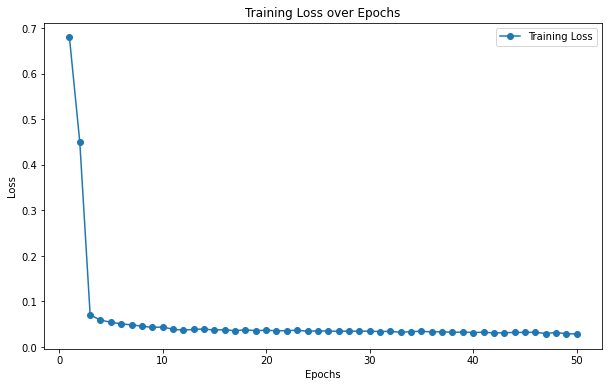

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

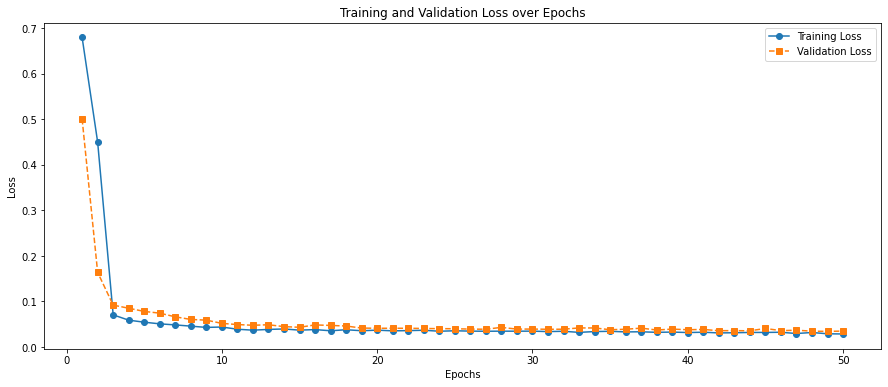

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 23ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.19336880860609307
MAE : 0.1475600451052646


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,524055.343750,282691.615
1,344414.406250,71897.386
2,293394.750000,60592.380
3,342824.562500,131973.043
4,445154.312500,753595.099
5,589053.250000,909176.475
6,786278.000000,917006.278
7,872883.937500,906368.363
8,917493.375000,917403.622
9,902654.000000,910653.838


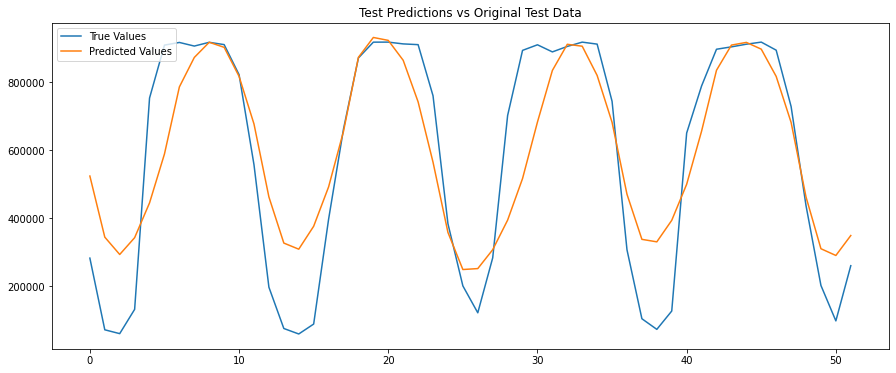

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

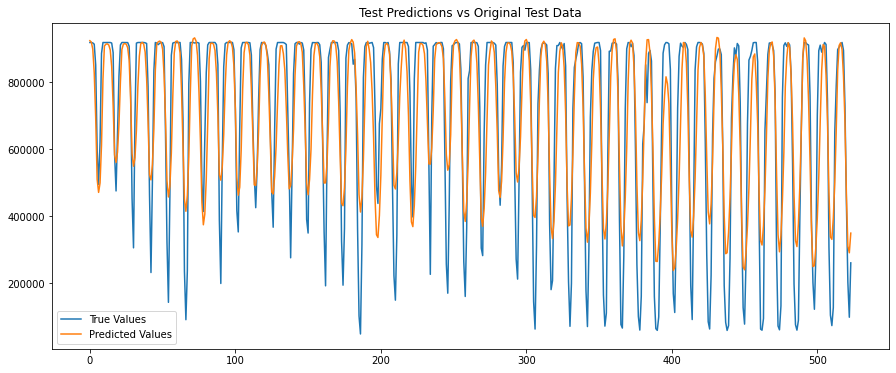

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()